# Analysis of hover points

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from firefly_preprocessing import get_dfs
import scipy
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
from scipy import signal

from tools import data_loader

In [2]:
# capture output of get_dfs function

In [3]:
%%capture     


data_directory = ['../flight_data/2021-12-10_hangar', '../flight_data/2022-01-24_hangar',
                  '../flight_data/2022-01-24_hangar']

ulg_number = [109, 143, 145]
firefly_number = [54, 5, 9]

log_number = 0
firefly_df, arm_df, ulg_df = get_dfs(data_directory[log_number],
                                         ulg_number[log_number], firefly_number[log_number])

In [4]:
# get motor data and calculate power

current = data_loader.get_current(firefly_df)
voltage = data_loader.get_voltage(firefly_df)
rpm = data_loader.get_rpm(firefly_df)
power = data_loader.get_power(firefly_df)

total_power = sum(power.values())

time = firefly_df.index.values

In [5]:
# get positions, velocities and angular rates

x = ulg_df['ulg_pv_df']['x'].values
y = ulg_df['ulg_pv_df']['y'].values
z = ulg_df['ulg_pv_df']['z'].values

u = ulg_df['ulg_pv_df']['vx'].values
v = ulg_df['ulg_pv_df']['vy'].values
w = ulg_df['ulg_pv_df']['vz'].values

p = ulg_df['ulg_angvel_df']['roll rate'].values
q = ulg_df['ulg_angvel_df']['pitch rate'].values
r = ulg_df['ulg_angvel_df']['yaw rate'].values

In [6]:
# global plotting settings
markersize = 3
cmap = cm.cool

# set t0 and t1 to plot only part of time domain
t0 = 0
t1 = time.size

In [7]:
# calculate velocity throug derivation of position

dt = time[1] - time[0]
dy = np.gradient(y, dt)
dx = np.gradient(x, dt)
dz = np.gradient(z, dt)


<IPython.core.display.Javascript object>


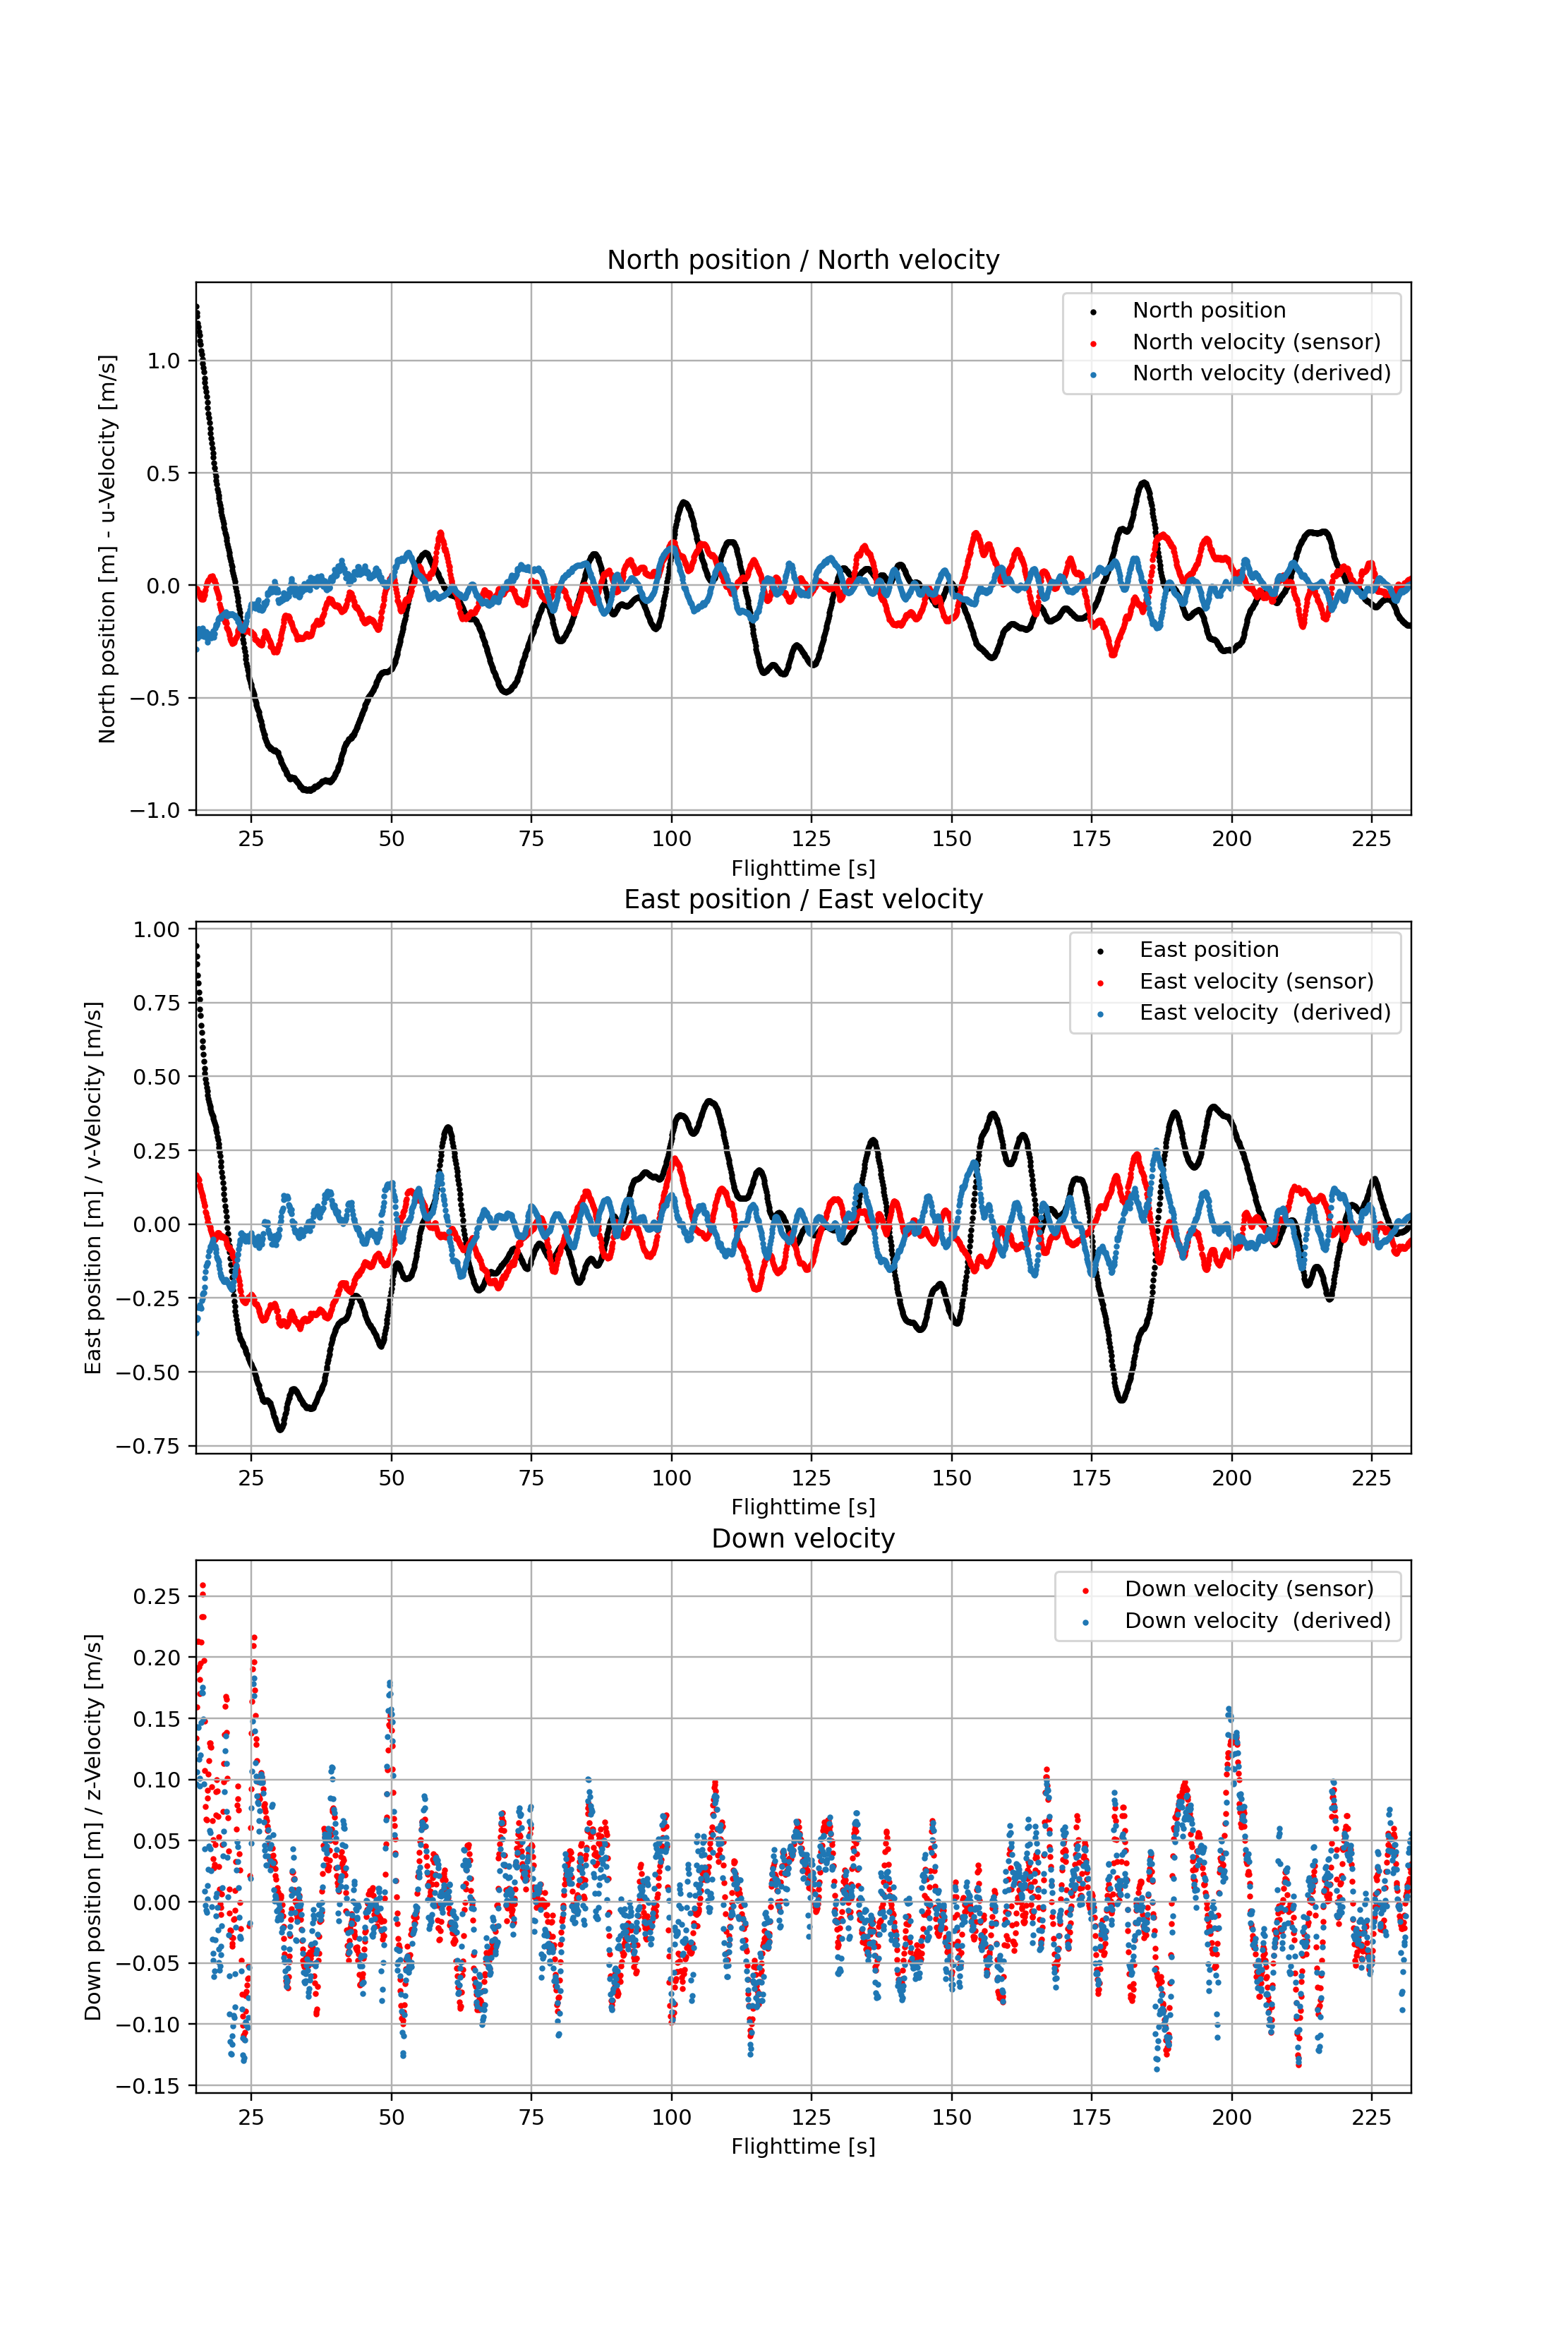

Text(0.5, 1.0, 'Down velocity')

In [8]:
# plot sensor values and calculated values for position and velocity

fig1, ax1 = plt.subplots(3,1, figsize=(10,15))

# plot position from sensor
ax1[0].scatter(time[t0:t1], y[t0:t1], c='k', label='North position', s=markersize)
ax1[1].scatter(time[t0:t1], x[t0:t1], c='k', label='East position', s=markersize)
#ax1[2].scatter(time[t0:t1], z[t0:t1], c='k', label='z (Down)', s=markersize)

# plot velocity from sensor
ax1[0].scatter(time[t0:t1], u[t0:t1], c='r', label='North velocity (sensor)', s=markersize)
ax1[1].scatter(time[t0:t1], v[t0:t1], c='r', label='East velocity (sensor)', s=markersize)
ax1[2].scatter(time[t0:t1], w[t0:t1], c='r', label='Down velocity (sensor)', s=markersize)
#ax1.scatter(time[t0:t1], u[t0:t1]-curve.reshape(-1)[t0:t1], c='r', label='u (sensor)', s=markersize)

# plot derived velocity
ax1[0].scatter(time[t0:t1], dy[t0:t1], c='tab:blue', label='North velocity (derived)', s=markersize)
ax1[1].scatter(time[t0:t1], dx[t0:t1], c='tab:blue', label='East velocity  (derived)', s=markersize)
ax1[2].scatter(time[t0:t1], dz[t0:t1], c='tab:blue', label='Down velocity  (derived)', s=markersize)

# plot integrated position
#ax1.scatter(time[t0:t1], pos_int[t0:t1], c='tab:cyan', label='North (integrated)', s=markersize)

for i in range(3):
    ax1[i].set_xlim(time[0], time[-1])
    ax1[i].grid()
    ax1[i].legend()
    ax1[i].set_xlabel('Flighttime [s]')

ax1[0].set_ylabel('North position [m] - u-Velocity [m/s]')
ax1[1].set_ylabel('East position [m] / v-Velocity [m/s]')
ax1[2].set_ylabel('Down position [m] / z-Velocity [m/s]')

ax1[0].set_title('North position / North velocity')
ax1[1].set_title('East position / East velocity')
ax1[2].set_title('Down velocity')

## Findings
* velocity signal in north and east direction does not match position signal-> both u and v are constantly above 0, the vehicle would drift away, if they were correct

<IPython.core.display.Javascript object>


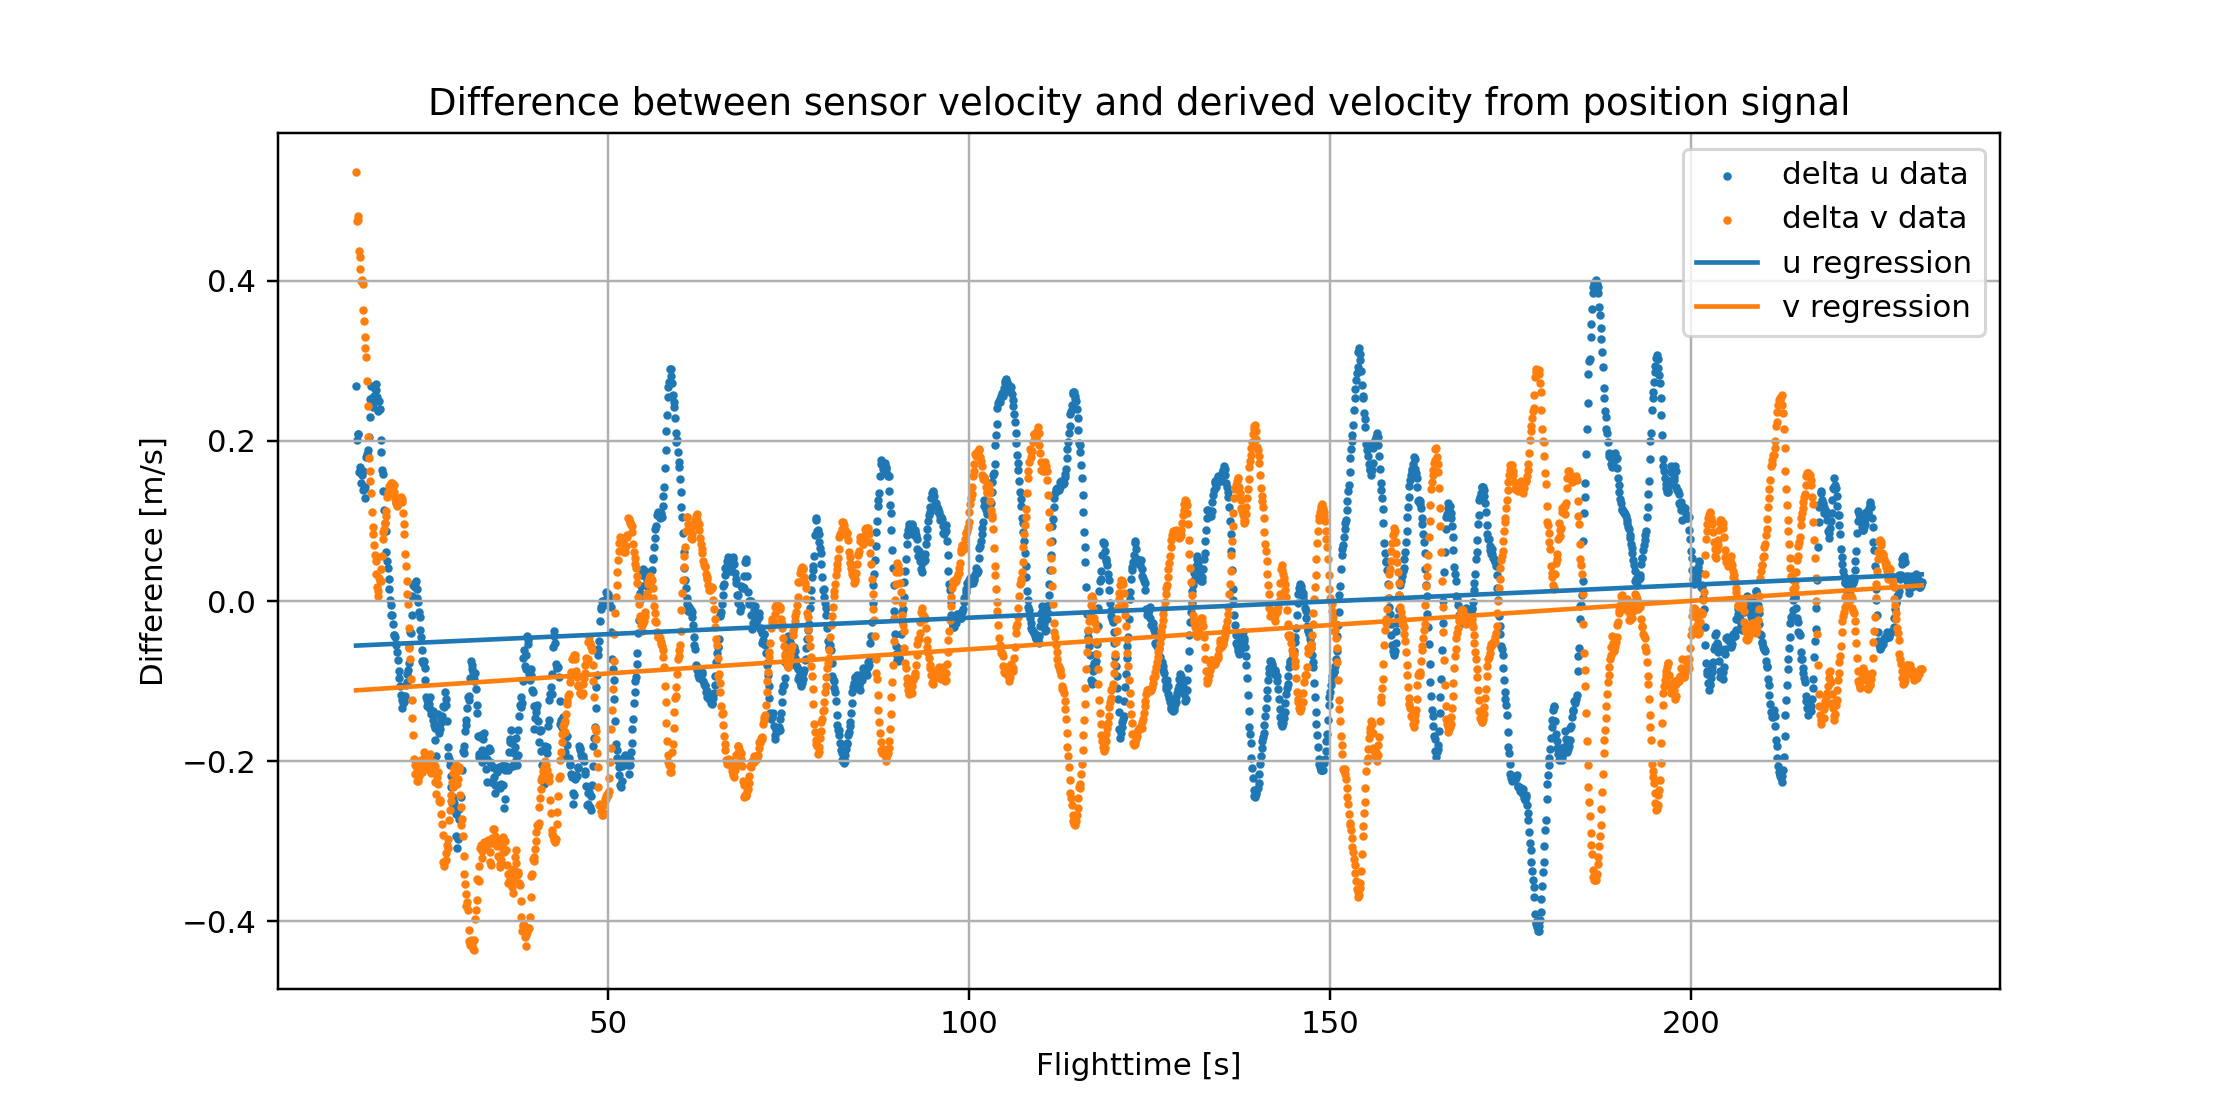

In [9]:
# Plot difference between sensor velocity and derived velocity

u_difference = u - dy
v_difference = v - dx

# Linear regression model for velocit difference
u_reg = linear_model.LinearRegression().fit(time.reshape(-1,1), u_difference.reshape(-1,1))
v_reg = linear_model.LinearRegression().fit(time.reshape(-1,1), v_difference.reshape(-1,1))

u_curve = u_reg.predict(time.reshape(-1,1))
v_curve = v_reg.predict(time.reshape(-1,1))

fig2, ax2 = plt.subplots(figsize=(10,5))
ax2.scatter(time, u_difference, s=markersize, label = 'delta u data')
ax2.scatter(time, v_difference, s=markersize, label = 'delta v data')

ax2.plot(time, u_curve, label = 'u regression')
ax2.plot(time, v_curve, label = 'v regression')

ax2.set_title('Difference between sensor velocity and derived velocity from position signal')
ax2.set_xlabel('Flighttime [s]')
ax2.set_ylabel('Difference [m/s]')
ax2.grid()
ax2.legend()

## Finding a criteria for hovering

As a first step, we need a criteria to identify hover points in the data. Using the norm of the velocit vector is a simple first approach.

$v_{norm} = ||v|| = \sqrt{\textbf{u}² + \textbf{v}² + \textbf{w}²}$

A fraction of the induced velocity functions as a threshold for $v_{norm}$

$v_i = \sqrt{\frac{W}{2 \rho A}}$

With a vehicle weight of 15 kg, standard air density of 1.225 kg/m³, and four pairs of rotors with 12 in radius, the induced velocity is:

In [10]:
W = 15*9.81
rho = 1.225
A = np.pi * (0.3048**2)
v_i = np.sqrt((2*W)/(rho*4*A))
print("Induced velocity: {} m/s".format(v_i))


Induced velocity: 14.345219306215128 m/s


In [11]:
# get vnorm of sensor and derived velocity
v_norm = ulg_df['ulg_pv_df']['vnorm'].values
dv_norm = np.sqrt(dx**2 + dy**2 + dz**2)

In [12]:
# set percentage of induced velocity as a limit
v_limit = 0.07
dv_limit = 0.05 # 0.5% of induced velocity

In [13]:
# filter out values above v_limit
filtered_indices_v = np.where(v_norm < v_limit)[0]
filtered_indices_dv = np.where(dv_norm < dv_limit)[0]

<IPython.core.display.Javascript object>


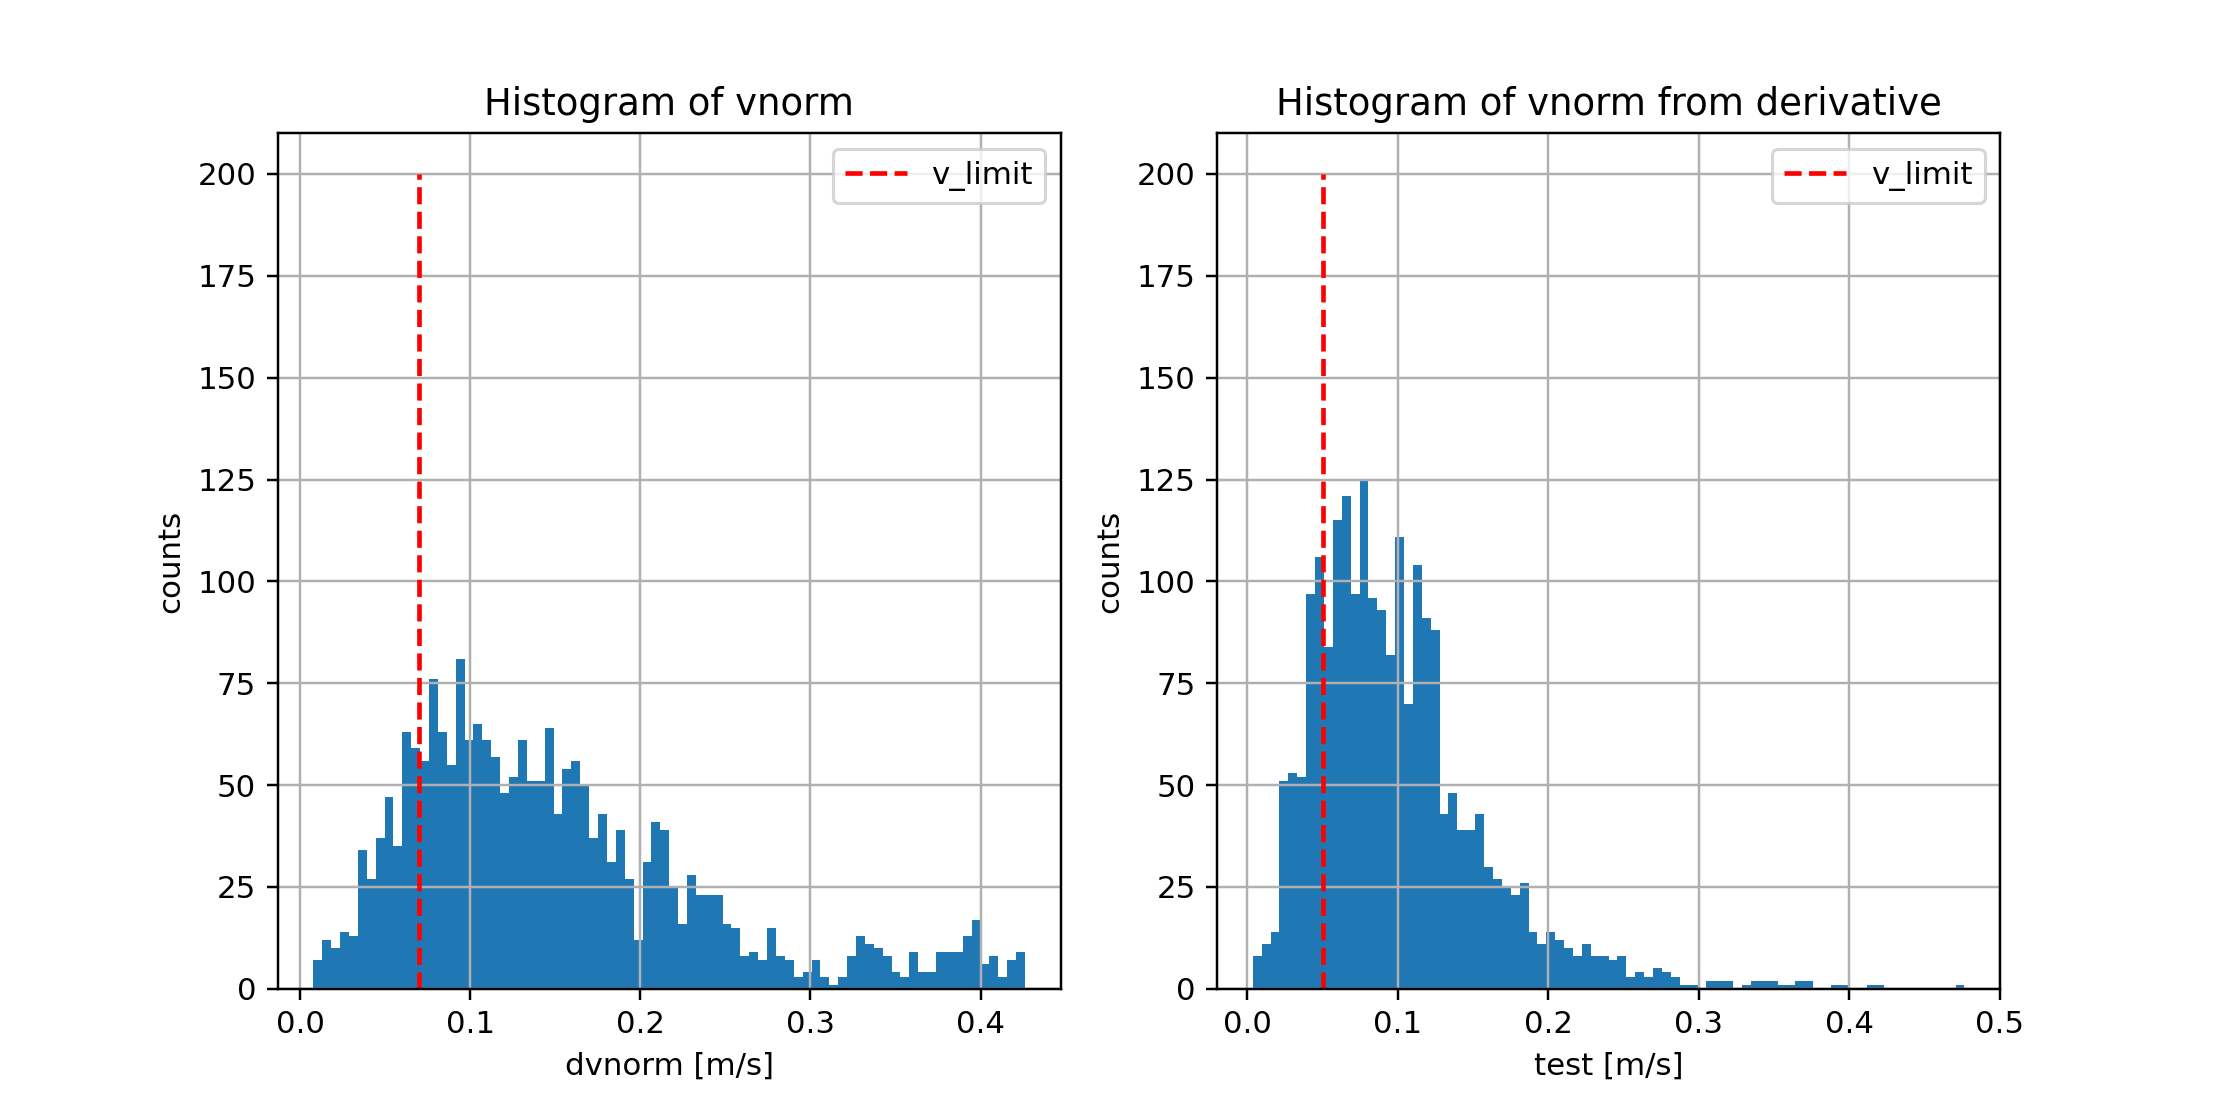

In [14]:
# plot histogram of vnorm with corresponding limit

fig4, ax4 = plt.subplots(1, 2, figsize=(10,5))

ax4[0].hist(v_norm, bins=80)
ax4[0].plot([v_limit, v_limit],[0, 200], 'r--', label='v_limit')
ax4[0].set_xlabel('dvnorm [m/s]')
ax4[0].set_ylabel('counts')
ax4[0].set_title('Histogram of vnorm')
ax4[0].grid()
ax4[0].legend()

ax4[1].hist(dv_norm, bins=80)
ax4[1].plot([dv_limit, dv_limit],[0, 200], 'r--', label='v_limit')
ax4[1].set_xlabel('test [m/s]')
ax4[1].set_ylabel('counts')
ax4[1].set_title('Histogram of vnorm from derivative')
ax4[1].grid()
ax4[1].legend()


<IPython.core.display.Javascript object>


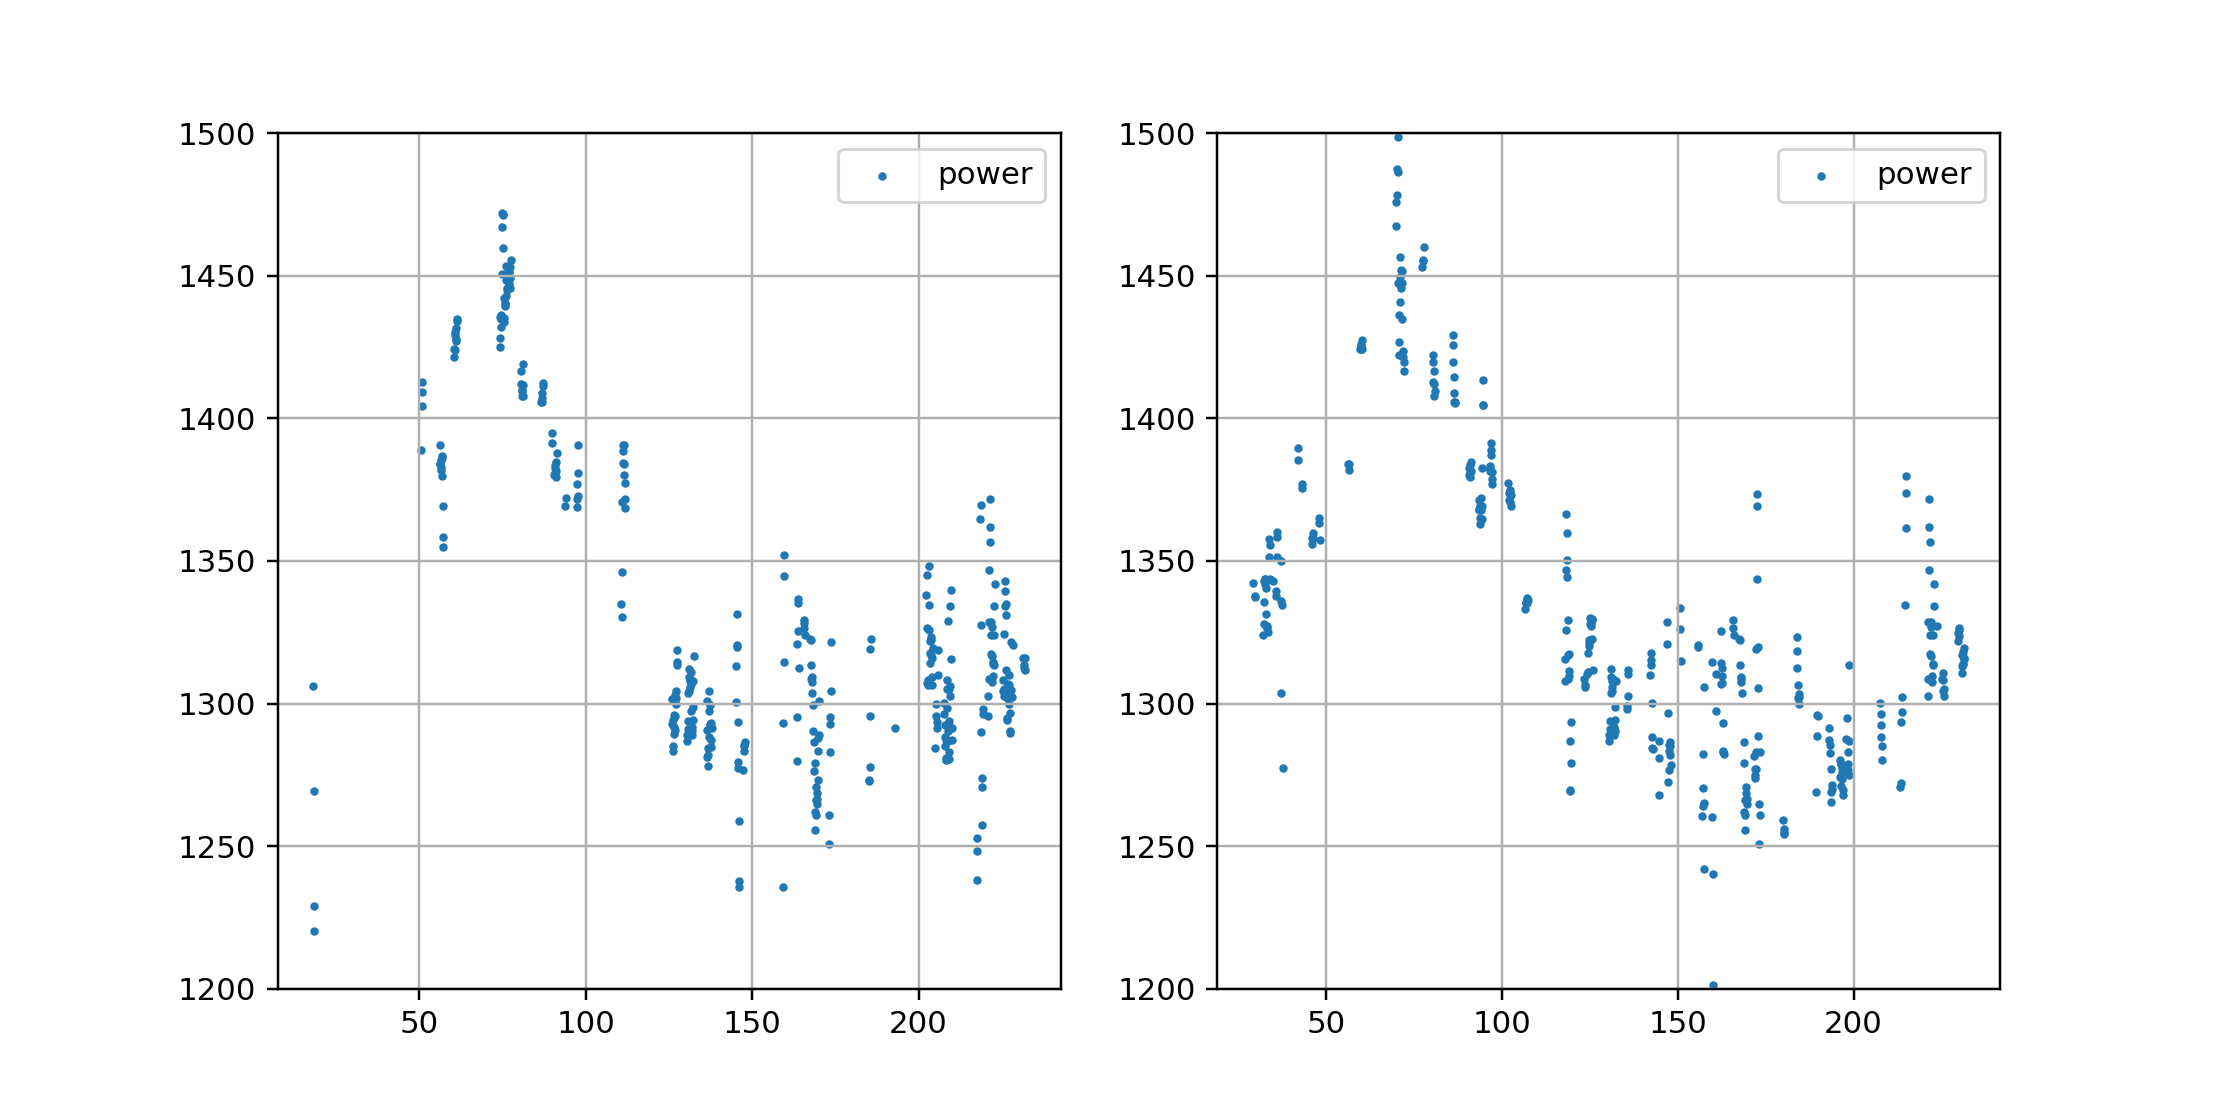

Mean power (raw) = 1333.6112902191724
Std power (raw) = 56.85196396880406
Mean power (filtered) = 1331.4282172608705
Std power (filtered) = 53.046228858740484


In [15]:
# Plot power data points of filtered values

fig3, ax3 = plt.subplots(1,2, figsize=(10,5))

ax3[0].scatter(time[filtered_indices_v], total_power[filtered_indices_v], s=markersize, label='power')
ax3[0].set_ylim(1200,1500)
ax3[0].grid()
ax3[0].legend()

ax3[1].scatter(time[filtered_indices_dv], total_power[filtered_indices_dv], s=markersize, label='power')
ax3[1].set_ylim(1200,1500)
ax3[1].grid()
ax3[1].legend()

print("Mean power (raw) = {}".format(np.mean(total_power[filtered_indices_v])))
print("Std power (raw) = {}".format(np.std(total_power[filtered_indices_v])))

print("Mean power (filtered) = {}".format(np.mean(total_power[filtered_indices_dv])))
print("Std power (filtered) = {}".format(np.std(total_power[filtered_indices_dv])))

In [16]:
def split_sequences(index_array, min_length=0):
    """ splits the index array into sequences. Discards sequences with length below min_length"""
    
    sequences = []

    ptr1 = 0
    ptr2 = 0

    while ptr1 < index_array.size:
        sequence = []
        while ptr1 < index_array.size and index_array[ptr1] == ptr2 :
            sequence.append(index_array[ptr1])
            ptr1 += 1
            ptr2 += 1
        if sequence and len(sequence) >= min_length:
            sequences.append(sequence)
        ptr2 += 1
    return sequences

In [30]:
# Split sequences and discard all sequences below a given length
min_length = 10
sequences = split_sequences(filtered_indices_v, min_length)
print("Found {} sequences with minimum length of {}".format(len(sequences), min_length))

Found 13 sequences with minimum length of 10


In [31]:
# Get length and standard deviation of all sequences
for index, seq in enumerate(sequences):
    print("Sequence {} with length {} : sigma={}".format(index, len(seq), np.std(seq)))

Sequence 0 with length 12 : sigma=3.452052529534663
Sequence 1 with length 10 : sigma=2.8722813232690143
Sequence 2 with length 34 : sigma=9.810708435174291
Sequence 3 with length 13 : sigma=3.7416573867739413
Sequence 4 with length 17 : sigma=4.898979485566356
Sequence 5 with length 21 : sigma=6.0553007081949835
Sequence 6 with length 16 : sigma=4.6097722286464435
Sequence 7 with length 11 : sigma=3.1622776601683795
Sequence 8 with length 16 : sigma=4.6097722286464435
Sequence 9 with length 20 : sigma=5.766281297335398
Sequence 10 with length 26 : sigma=7.5
Sequence 11 with length 21 : sigma=6.0553007081949835
Sequence 12 with length 25 : sigma=7.211102550927978


<IPython.core.display.Javascript object>


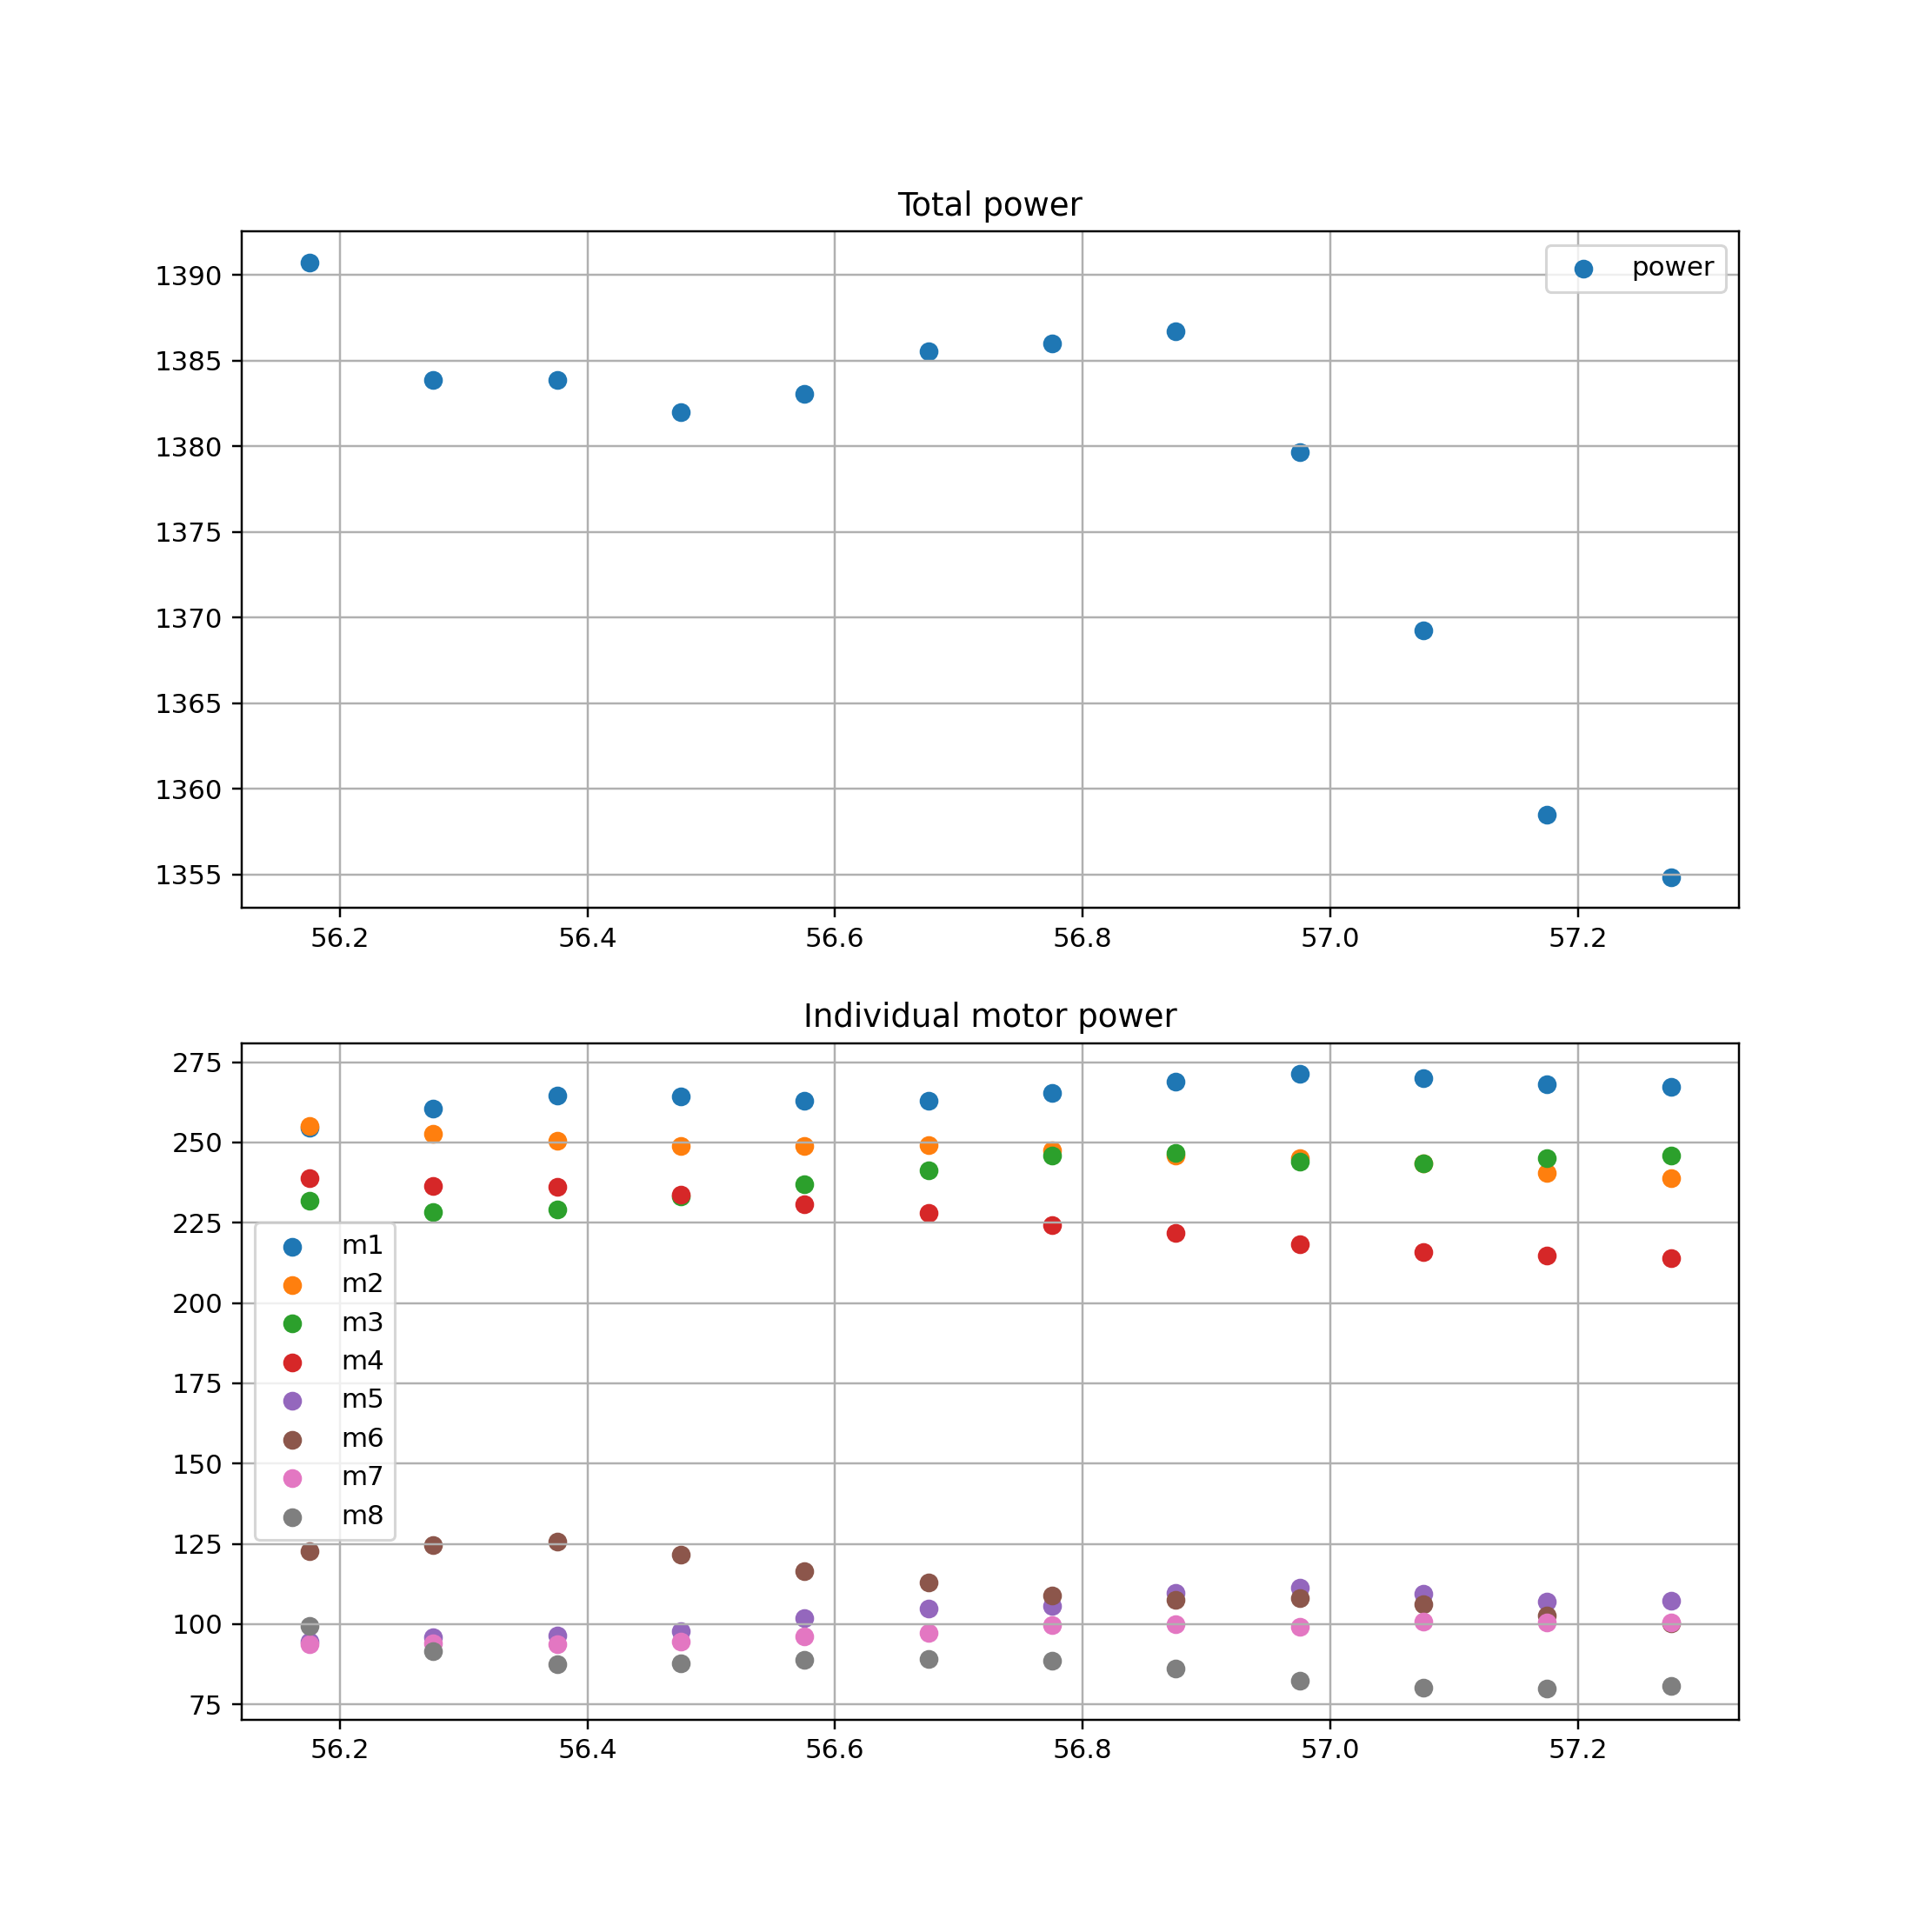

In [32]:
# Plot total power during a given sequence
index = sequences[0]

fig5, ax5 = plt.subplots(2,1, figsize=(10,10))

ax5[0].scatter(time[index], total_power[index], label='power')
ax5[0].set_title('Total power')
#ax5[0].set_xlim(time[index[0]], index[-1]/10)
ax5[0].grid()
ax5[0].legend()

ax5[1].scatter(time[index], power['11'][index], label='m1')
ax5[1].scatter(time[index], power['12'][index], label='m2')
ax5[1].scatter(time[index], power['13'][index], label='m3')
ax5[1].scatter(time[index], power['14'][index], label='m4')
ax5[1].scatter(time[index], power['15'][index], label='m5')
ax5[1].scatter(time[index], power['16'][index], label='m6')
ax5[1].scatter(time[index], power['17'][index], label='m7')
ax5[1].scatter(time[index], power['18'][index], label='m8')
ax5[1].set_title('Individual motor power')
ax5[1].grid()
ax5[1].legend()